## Packages

In [1]:
import numpy as np
from pickle import load, dump
import string
from os import listdir

from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical, plot_model

from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/home/sb/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Image features

#### Load pre-trained VGG model

In [2]:
# Load VGG model from keras
vgg_model = VGG16()

# Remove last layer
vgg_model.layers.pop()
vgg_model = Model(inputs = vgg_model.inputs, outputs = vgg_model.layers[-1].output)
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

#### Check sample image VGG output feature

data/Flicker8k_Dataset/49553964_cee950f3ba.jpg


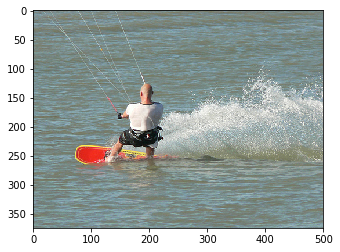

In [3]:
## Pick an image

!ls data/Flicker8k_Dataset/49553964_cee950f3ba.jpg
img_file = '49553964_cee950f3ba.jpg'
img_full_path = 'data/Flicker8k_Dataset/' + img_file

img = plt.imread(img_full_path)
plt.imshow(img, interpolation='nearest')

In [4]:
## Get image VGG features

def get_image_vgg_feature(img_full_path, vgg_model):
    
    # Load image
    img = load_img(img_full_path, target_size = (224, 224))
    print("After Keras load_img:", type(img))
    # Convert to np array
    img = img_to_array(img)
    print("After Keras image to np array:", type(img), img.shape)
    # Reshape and add batch dimension
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    print("After np img Reshape:", type(img), img.shape)
    # Preprocess for vgg
    img = preprocess_input(img)
    print("After VGG Preprocess:", type(img), img.shape)
    # Predict features
    pred_feature = vgg_model.predict(img)
    print("VGG Predicted feature:", type(pred_feature), pred_feature.shape)
    print(pred_feature[0])

    return pred_feature

get_image_vgg_feature(img_full_path, vgg_model)

After Keras load_img: <class 'PIL.Image.Image'>
After Keras image to np array: <class 'numpy.ndarray'> (224, 224, 3)
After np img Reshape: <class 'numpy.ndarray'> (1, 224, 224, 3)
After VGG Preprocess: <class 'numpy.ndarray'> (1, 224, 224, 3)
VGG Predicted feature: <class 'numpy.ndarray'> (1, 4096)
[ 0.          0.          0.         ...,  0.          0.          4.03627729]


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  4.03627729]], dtype=float32)

#### Process and Store Image features

In [5]:
# Get pre-trained VGG features for all the images
def get_image_vgg_features(image_data_dir, model, model_name):
    
    # Store dictionary img -> img_feature
    img_features = dict()
    img_files = listdir(image_data_dir)
    print("Found number of images:", len(img_files))
    for img_file in img_files:  
        img_id = img_file.split('.')[0]  ; # remove jpg
        img_full_path = image_dir + img_file 
        img = load_img(img_full_path, target_size = (224, 224))
        img = img_to_array(img)
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        img_features[img_id] = model.predict(img)
    
    # Print dictionary as pickle file 
    img_feature_file = 'scratch/' + model_name + '_image_features.pkl'
    dump(img_features, open(img_feature_file, 'wb'))

# Run the above function - when running it first time
image_data_dir = 'data/Flicker8k_Dataset'
if False:
    img_features = get_image_vgg_features(image_data_dir, vgg_model, 'vgg')

#### Store train, validation and test image features separately (subset of above features)

In [6]:
# Get image names listed in train dataset
train_images_file = 'data/Flickr8k_text/Flickr_8k.trainImages.txt'
train_images_ids = list()
fp = open(train_images_file, 'r')
train_images_file_lines = fp.read()
for line in train_images_file_lines.split('\n'):
    if len(line) < 1: continue
    img_id = line.split('.')[0]
    train_images_ids.append(img_id)
fp.close()
train_images_ids = set(train_images_ids)
print("Found {} train image names".format(len(train_images_ids)))

# Load the features pickle file
img_feature_file = 'scratch/' + 'vgg' + '_image_features.pkl'
pkl_features = load(open(img_feature_file, 'rb'))
print("Loaded image features from ", img_feature_file)

# Load train img features 
train_img_features = {img_id: pkl_features[img_id] for img_id in train_images_ids}
print("Loaded {} train image features".format(len(train_img_features)))

Found 6000 train image names
Loaded image features from  scratch/vgg_image_features.pkl
Loaded 6000 train image features


In [7]:
# Get image names listed in validation dataset
val_images_file = 'data/Flickr8k_text/Flickr_8k.devImages.txt'
val_images_ids = list()
fp = open(val_images_file, 'r')
val_images_file_lines = fp.read()
for line in val_images_file_lines.split('\n'):
    if len(line) < 1: continue
    img_id = line.split('.')[0]
    val_images_ids.append(img_id)
fp.close()
val_images_ids = set(val_images_ids)
print("Found {} validation image names".format(len(val_images_ids)))

# Load the features pickle file
img_feature_file = 'scratch/' + 'vgg' + '_image_features.pkl'
pkl_features = load(open(img_feature_file, 'rb'))
print("Loaded image features from ", img_feature_file)

# Load val img features 
val_img_features = {img_id: pkl_features[img_id] for img_id in val_images_ids}
print("Loaded {} validation image features".format(len(val_img_features)))

Found 1000 validation image names
Loaded image features from  scratch/vgg_image_features.pkl
Loaded 1000 validation image features


In [8]:
# Get image names listed in test dataset
test_images_file = 'data/Flickr8k_text/Flickr_8k.testImages.txt'
test_images_ids = list()
fp = open(test_images_file, 'r')
test_images_file_lines = fp.read()
for line in test_images_file_lines.split('\n'):
    if len(line) < 1: continue
    img_id = line.split('.')[0]
    test_images_ids.append(img_id)
fp.close()
test_images_ids = set(test_images_ids)
print("Found {} test image names".format(len(test_images_ids)))

# Load the features pickle file
img_feature_file = 'scratch/' + 'vgg' + '_image_features.pkl'
pkl_features = load(open(img_feature_file, 'rb'))
print("Loaded image features from ", img_feature_file)

# Load test img features 
test_img_features = {img_id: pkl_features[img_id] for img_id in test_images_ids}
print("Loaded {} test image features".format(len(test_img_features)))

Found 1000 test image names
Loaded image features from  scratch/vgg_image_features.pkl
Loaded 1000 test image features


## Caption features

#### Load, clean-up and Store Captions

In [9]:
# Load caption data
def get_caption_data(caption_data_file):

    # Load the file
    fp = open(caption_data_file, 'r')
    caption_data = fp.read()
    caption_data_lines = caption_data.split('\n')
    fp.close()

    # Map img -> caption or list of captions.
    captions_of_img = dict()
    for caption_line in caption_data_lines:
        # Get words
        words = caption_line.split()
        if len(words) < 2: continue
        # image
        img_id = words[0].split('.')[0] 
        # caption
        img_caption_words = words[1:]
        # clean up caption (remove punctuations, numeric, punctuation, 1 letter words)
        img_caption_words_new = [word.lower() for word in img_caption_words]
        img_caption_words_new = [word for word in img_caption_words_new if word.isalpha()]
        img_caption_words_new = [word.translate(str.maketrans("","",string.punctuation)) for word in img_caption_words_new]
        img_caption_words_new = [word for word in img_caption_words_new if len(word) > 1]
        # add start and end token to caption
        img_caption = "startseq " + " ".join(img_caption_words_new) + " endseq"     
        # store caption
        if img_id not in captions_of_img :  captions_of_img[img_id] = list()
        captions_of_img[img_id].append(img_caption)
        
    return captions_of_img
        
# Run the above function
caption_data_file = 'data/Flickr8k_text/Flickr8k.token.txt' 
captions_of_img = get_caption_data(caption_data_file)
print("Finished reading captions for {} images".format(len(captions_of_img)))

# Check sample img captions
print("Example image caption:")
captions_of_img['1000268201_693b08cb0e']

Finished reading captions for 8092 images
Example image caption:


['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

#### Create training. validation and test image captions (filter out from all captions created above)

In [10]:
# Filter captions for train images of captions for tokenizer
captions_of_train_img = dict()
for img_id in captions_of_img.keys():
    if img_id in train_images_ids:
        for caption in captions_of_img[img_id]:
            if img_id not in captions_of_train_img:  captions_of_train_img[img_id] = list()
            captions_of_train_img[img_id].append(caption)
print("Created captions for {} train images. \nExample:\n".format(len(captions_of_train_img))) 
print(captions_of_train_img['1000268201_693b08cb0e'])

Created captions for 6000 train images. 
Example:

['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq']


In [11]:
# Filter captions for validation images of captions for tokenizer
captions_of_val_img = dict()
for img_id in captions_of_img.keys():
    if img_id in val_images_ids:
        for caption in captions_of_img[img_id]:
            if img_id not in captions_of_val_img:  captions_of_val_img[img_id] = list()
            captions_of_val_img[img_id].append(caption)
print("Created captions for {} validation images. \nExample:\n".format(len(captions_of_val_img))) 
print(captions_of_val_img['1022454332_6af2c1449a'])

Created captions for 1000 validation images. 
Example:

['startseq child and woman are at waters edge in big city endseq', 'startseq large lake with lone duck swimming in it with several people around the edge of it endseq', 'startseq little boy at lake watching duck endseq', 'startseq young boy waves his hand at the duck in the water surrounded by green park endseq', 'startseq two people are at the edge of lake facing the water and the city skyline endseq']


In [12]:
# Filter captions for test images of captions for tokenizer
captions_of_test_img = dict()
for img_id in captions_of_img.keys():
    if img_id in test_images_ids:
        for caption in captions_of_img[img_id]:
            if img_id not in captions_of_test_img:  captions_of_test_img[img_id] = list()
            captions_of_test_img[img_id].append(caption)
print("Created captions for {} test images. \nExample:\n".format(len(captions_of_test_img))) 
print(captions_of_test_img['1056338697_4f7d7ce270'])

Created captions for 1000 test images. 
Example:

['startseq blond woman in blue shirt appears to wait for ride endseq', 'startseq blond woman is on the street hailing taxi endseq', 'startseq woman is signaling is to traffic as seen from behind endseq', 'startseq woman with blonde hair wearing blue tube top is waving on the side of the street endseq', 'startseq the woman in the blue dress is holding out her arm at oncoming traffic endseq']


#### Create tokenizer for all train data captions

In [13]:
# Create tokenizer for all train words
def get_tokenizer(captions_of_img):
    
    # create list of captions for tokenizer
    captions = list()
    for img_id in captions_of_img.keys():
        [captions.append(caption) for caption in captions_of_img[img_id]] 
    
    # get max caption length
    max_caption_length = max(len(caption.split()) for caption in captions)
    
    # Create and fit tokenizer
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions)
    
    return tokenizer, max_caption_length

# Run the above function
caption_tokenizer, max_caption_length = get_tokenizer(captions_of_train_img)
vocab_size = len(caption_tokenizer.word_index) + 1
print("Finished fitting tokenizer on caption.\nVocab size is:", vocab_size)
print("Max caption length is:", max_caption_length)

# Check sample caption tokens
tokenized_seq = caption_tokenizer.texts_to_sequences(['girl going into wooden building'])
print("Example tokenized_seq type and output", type(tokenized_seq), tokenized_seq[0])
print("Tokens of girl, wooden, going:")
caption_tokenizer.word_index['girl'], caption_tokenizer.word_index['wooden'], caption_tokenizer.word_index['into']

Finished fitting tokenizer on caption.
Vocab size is: 7266
Max caption length is: 33
Example tokenized_seq type and output <class 'list'> [18, 312, 64, 195, 118]
Tokens of girl, wooden, going:


(18, 195, 64)

In [14]:
# Save the caption tokenizer
dump(caption_tokenizer, open('models/caption_tokenizer.pkl', 'wb'))

## Image + caption features per image

#### Generator function: Load few images at time into memory for training - avoids memory error during model.fit

In [15]:
def generator_train_data(train_img_features, captions_of_img, caption_tokenizer, max_caption_length, vocab_size):
    
    while 1:
        
        for img_id, captions in captions_of_img.items():
            
            # Input and output
            image_features_batch = list()
            caption_in_features_batch = list()
            caption_out_feature_batch = list() 
            
            # Image feature 
            img_feature = train_img_features[img_id][0]
            
            # Caption feature
            captions = captions_of_img[img_id]
            for caption in captions:
                caption_seq = caption_tokenizer.texts_to_sequences([caption])[0]
                # Split into multiple train examples
                # img word1 -> word2 ; img word1 word2 -> word3 ; etc
                for word_idx in range(1, len(caption_seq)):
                    caption_seq_in = caption_seq[:word_idx]
                    caption_seq_out = caption_seq[word_idx]
                    # Pad input sequence to max length using keras
                    caption_seq_in = pad_sequences([caption_seq_in], maxlen = max_caption_length)[0]
                    # One-hot encode output word
                    caption_seq_out = to_categorical([caption_seq_out], num_classes = vocab_size)[0]
                    
                    # Training example:
                    image_features_batch.append(img_feature)
                    caption_in_features_batch.append(caption_seq_in)
                    caption_out_feature_batch.append(caption_seq_out)
                    
            # Yield the feature vector
            yield [ [np.array(image_features_batch), np.array(caption_in_features_batch)], \
                     np.array(caption_out_feature_batch) ]

## Model

#### Define and fit the model

In [16]:
# Define the final model
def caption_model(max_caption_length, vocab_size):
    
    # image pre-trained feature
    in1 = Input( shape = (4096,) )  
    x1 = Dropout(0.5)(in1)
    x1 = Dense(256, activation='relu')(x1)
    
    # caption - convert to embedding
    in2 = Input( shape = (max_caption_length,) )
    x2 = Embedding(vocab_size, 256, mask_zero=True)(in2)
    x2 = Dropout(0.5)(x2)
    x2 = LSTM(256)(x2)
    
    # merge image and caption
    x = add([x1, x2])
    x = Dense(256, activation = 'relu')(x)
    x = Dense(vocab_size, activation = 'softmax')(x)
    
    # model
    model = Model(inputs = [in1, in2], outputs = x)
    
    return model

caption_model = caption_model(max_caption_length, vocab_size)
caption_model.summary()
#plot_model(caption_model, to_file="scratch/caption_model.png")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 33)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 33, 256)      1860096     input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [17]:
# Compile and fit the model
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the model
num_epochs = 15
steps = len(captions_of_train_img)
for epoch_idx in range(num_epochs):
    generator_func = generator_train_data(train_img_features, captions_of_train_img, caption_tokenizer, 
                                          max_caption_length, vocab_size)
    caption_model.fit_generator(generator_func, epochs=1, steps_per_epoch=steps, verbose=1)
    caption_model.save('models/model_' + str(epoch_idx) + '.h5')

Epoch 1/1
6000/6000 [==============================] - 373s 62ms/step - loss: 4.6504
Epoch 1/1
6000/6000 [==============================] - 369s 61ms/step - loss: 3.8974
Epoch 1/1
6000/6000 [==============================] - 373s 62ms/step - loss: 3.6476
Epoch 1/1
6000/6000 [==============================] - 371s 62ms/step - loss: 3.4999
Epoch 1/1
6000/6000 [==============================] - 368s 61ms/step - loss: 3.4054
Epoch 1/1
6000/6000 [==============================] - 367s 61ms/step - loss: 3.3438
Epoch 1/1
6000/6000 [==============================] - 367s 61ms/step - loss: 3.2905
Epoch 1/1
6000/6000 [==============================] - 368s 61ms/step - loss: 3.2521
Epoch 1/1
6000/6000 [==============================] - 368s 61ms/step - loss: 3.2243
Epoch 1/1
6000/6000 [==============================] - 368s 61ms/step - loss: 3.2027
Epoch 1/1
6000/6000 [==============================] - 368s 61ms/step - loss: 3.1803
Epoch 1/1
6000/6000 [==============================] - 369s 61ms/

## Predict for new image

#### Load pre-trained VGG model and generate image feature

In [22]:
# Load VGG model from keras, and remove last layer
vgg_model = VGG16()
vgg_model.layers.pop()
vgg_model = Model(inputs = vgg_model.inputs, outputs = vgg_model.layers[-1].output)

## Get image VGG features
image_feature = get_image_vgg_feature(img_full_path, vgg_model)

After Keras load_img: <class 'PIL.Image.Image'>
After Keras image to np array: <class 'numpy.ndarray'> (224, 224, 3)
After np img Reshape: <class 'numpy.ndarray'> (1, 224, 224, 3)
After VGG Preprocess: <class 'numpy.ndarray'> (1, 224, 224, 3)
VGG Predicted feature: <class 'numpy.ndarray'> (1, 4096)
[ 0.          0.76115489  4.73178005 ...,  0.          0.61450362  0.        ]


#### Load trained model and parameters

In [35]:
# Model
model_file = 'models/model_1.h5'
trained_caption_model = load_model(model_file)

In [26]:
# Caption tokenizer 
trained_caption_tokenizer = load(open('models/caption_tokenizer.pkl', 'rb'))

# Max caption length - should match training set
max_caption_length = 33

#### Predictor function

In [28]:
# Recursively generate next word in caption till max caption length is reached or 'endseq' is hit
def get_caption(model, caption_tokenizer, image_feature, max_caption_length):
    
    # start caption
    found_word = None
    current_caption = 'startseq'
    
    # recursively generate next word
    for word_idx in range(max_caption_length):
        
        if found_word == 'endseq': break
        
        # Generate caption feature
        caption_seq = caption_tokenizer.texts_to_sequences([current_caption])[0]
        caption_seq = pad_sequences([caption_seq], maxlen = max_caption_length)
        
        # Make prediction
        word_vec = model.predict([image_feature, caption_seq])
        
        # Get highest probability word idx and corresponding word
        word_idx = np.argmax(word_vec)
        found_word = None
        for word, idx in caption_tokenizer.word_index.items():
            if idx == word_idx: 
                found_word = word
                break
        if found_word is None: break
        
        # Append found word to current caption
        current_caption += " " + found_word
    
    #print("Predicted Caption is:\n",current_caption) 
    
    return current_caption

'startseq black and white dog is running through the water endseq'

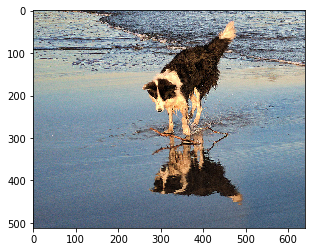

In [36]:
## Pick an image
img_full_path = 'data/sample_test_image.jpg'  
img = plt.imread(img_full_path)
plt.imshow(img, interpolation='nearest')

# Predict
get_caption(trained_caption_model, trained_caption_tokenizer, image_feature, max_caption_length)

## Evaluate the model

In [37]:
# Calculate bleu score using true and predicted captions
def evaluate_caption_model(caption_model, captions_of_img, img_features, caption_tokenizer, max_caption_length):

    true_captions = list()
    predicted_captions = list()

    for img_id, captions in captions_of_img.items():

        # True caption tokens 
        true_caption = [caption.split() for caption in captions]
        true_captions.append(true_caption)
        
        # Predicted caption tokens using get_caption defined above
        pred_caption = get_caption(caption_model, caption_tokenizer, img_features[img_id], max_caption_length)
        predicted_captions.append(pred_caption.split())
        
    # calculate BLEU score
    print("BLEU-1:", corpus_bleu(true_captions, predicted_captions, weights=(1.0, 0, 0, 0)))
    print("BLEU-2:", corpus_bleu(true_captions, predicted_captions, weights=(0.5, 0.5, 0, 0)))
    print("BLEU-3:", corpus_bleu(true_captions, predicted_captions, weights=(0.3, 0.3, 0.3, 0)))
    print("BLEU-4:", corpus_bleu(true_captions, predicted_captions, weights=(0.25, 0.25, 0.25, 0.25)))
    
# Run the function
evaluate_caption_model(trained_caption_model, captions_of_test_img, test_img_features, caption_tokenizer, max_caption_length)

BLEU-1: 0.5804647625953588
BLEU-2: 0.3241315906907817
BLEU-3: 0.22537129977339998
BLEU-4: 0.11005510827451902


In [38]:
# Load all models to check validation bleu-score
for model_epoch_idx in range(5):
    
    print("Model:{}\n".format(model_epoch_idx))
    
    # Model
    model_file = 'models/model_' + str(model_epoch_idx) + '.h5'
    trained_caption_model = load_model(model_file)
    
    # Get bleu-score
    evaluate_caption_model(trained_caption_model, captions_of_val_img, val_img_features, caption_tokenizer, max_caption_length) 
    
    print("\n")

Model:0

BLEU-1: 0.5901275497484225
BLEU-2: 0.33450821392046276
BLEU-3: 0.22895900535867966
BLEU-4: 0.10757893519172862


Model:1

BLEU-1: 0.5829500481334902
BLEU-2: 0.33287938781981
BLEU-3: 0.23590565460206903
BLEU-4: 0.11919825540726954


Model:2

BLEU-1: 0.568195534097767
BLEU-2: 0.31016623103943924
BLEU-3: 0.21427357898052676
BLEU-4: 0.10227044090431174


Model:3

BLEU-1: 0.5538702417066249
BLEU-2: 0.30858637147631407
BLEU-3: 0.21638549334881788
BLEU-4: 0.10638124978404628


Model:4

BLEU-1: 0.5063974236225955
BLEU-2: 0.2640354849567271
BLEU-3: 0.17912772963208734
BLEU-4: 0.08174628340340438




Model 1 has better bleu score upto 4-grams